# Exploratory Data Analysis

# Data Import

In [1]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [29]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('healthcare-dataset-stroke-data.csv')


Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (1).csv


# Data Exploration

In [30]:
random.seed(2024)

In [31]:
dtypes = df.dtypes
for column, dtype in dtypes.items():
  print(f"{column}: {dtype}")


id: int64
gender: object
age: float64
hypertension: int64
heart_disease: int64
ever_married: object
work_type: object
Residence_type: object
avg_glucose_level: float64
bmi: float64
smoking_status: object
stroke: int64


In [32]:
for column in df.columns:
  print(f"{column}: {df[column].unique()}")


id: [ 9046 51676 31112 ... 19723 37544 44679]
gender: ['Male' 'Female' 'Other']
age: [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01 4.00e-01 8.00e-02 1.

In [33]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#Data Cleaning

In [34]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [35]:
df['id'].duplicated().any()

False

In [36]:
df = df.drop(columns="id")
df.isnull().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [37]:
na_values_bmi = df['bmi'].isnull().sum()
na_values_bmi

201

There are about 201 entries in BMI that have no values. To help with their computation instead of taking the mean, which we believe wouldnt be the most accurate estimation, we will try to estimate the NA bmi values using KNN regressions with the numerical columns of this dataset

In [38]:
df_3=df.copy() # Just to check RMSE value with mean imputation

In [39]:
df_3 = df.copy()
# Fill missing BMI values with the mean
mean_bmi = df_3['bmi'].mean()
df_3['bmi'] = df_3['bmi'].fillna(mean_bmi)

# Calculate the RMSE
rmse_mean = np.sqrt(np.mean((df_3['bmi'] - mean_bmi) ** 2))

print(f'RMSE with mean imputation: {rmse_mean:.2f}')

RMSE with mean imputation: 7.70


In [40]:
# Define features for KNN imputation --> Numeric columns (no need for encoded categorical)
KNNCOLS = ['age', 'avg_glucose_level']

TARGET = 'stroke'
knn = KNeighborsClassifier(n_neighbors=100, metric='minkowski', n_jobs=-1)
knn.fit(df[KNNCOLS], df[TARGET])

dists, nears = knn.kneighbors(df[KNNCOLS], return_distance=True)

mse = np.mean([(df.loc[i, 'bmi'] - df.loc[nears[i][1:], 'bmi'].median()) ** 2
               for i in df.index if not pd.isna(df.loc[i, 'bmi'])])
rmse = round(mse ** 0.5, 2)
print(f'RMSE with KNN: {rmse}')

missing_bmi_indices = df[df['bmi'].isna()].index
for i in missing_bmi_indices:
    df.loc[i, 'bmi'] = df.loc[nears[i][1:], 'bmi'].median()


RMSE with KNN: 6.88


In [41]:
na_values_bmi = df['bmi'].isnull().sum()
na_values_bmi

0

In [42]:
df.isnull().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

In [43]:
print(df['gender'].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


In [44]:
df = df.drop(df[df.gender == "Other"].index)

The removal of this single data point is not expected to detrimentally affect the overall dataset or the subsequent model's accuracy, due to its negligible proportion relative to the size of the dataset.

#Creating Levels Lables

In [45]:
cat_cols = ["gender","Residence_type","smoking_status","ever_married","work_type"]
level_labels = {}
for i in cat_cols:
  factor, levels = pd.factorize(df[i])
  df[i] = factor
  level_labels[i] = dict(enumerate(levels))

level_labels = pd.DataFrame.from_dict(level_labels, orient='index')


level_labels.loc['ever_married', 1] = 'Yes'
level_labels.loc['ever_married', 0] = 'No'

level_labels.loc['smoking_status', 0] = 'never smoked'
level_labels.loc['smoking_status', 1] = 'formerly smoked'


In [46]:
level_labels

,0,1,2,3,4
gender,Male,Female,NaN,NaN,NaN
Residence_type,Urban,Rural,NaN,NaN,NaN
smoking_status,never smoked,formerly smoked,smokes,Unknown,NaN
ever_married,No,Yes,NaN,NaN,NaN
work_type,Private,Self-employed,Govt_job,children,Never_worked


In [47]:
for column in df.columns:
  print(f"{column}: {df[column].unique()}")

gender: [0 1]
age: [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01 4.00e-01 8.00e-02 1.48e+00 5.60e-01 4.80e-01 1.60e-01]
hypertension: [0 1]
heart_disea

                     gender       age  hypertension  heart_disease  \
gender             1.000000  0.027752     -0.021223      -0.085685   
age                0.027752  1.000000      0.276367       0.263777   
hypertension      -0.021223  0.276367      1.000000       0.108292   
heart_disease     -0.085685  0.263777      0.108292       1.000000   
ever_married      -0.030171 -0.679084     -0.164187      -0.114601   
work_type         -0.065848 -0.413428     -0.075150      -0.058301   
Residence_type    -0.006105 -0.014031      0.007980      -0.003045   
avg_glucose_level -0.054722  0.238323      0.174540       0.161907   
bmi                0.025241  0.334140      0.162020       0.043493   
smoking_status    -0.038918 -0.376161     -0.129133      -0.064753   
stroke            -0.009081  0.245239      0.127891       0.134905   

                   ever_married  work_type  Residence_type  avg_glucose_level  \
gender                -0.030171  -0.065848       -0.006105          -0.054722 

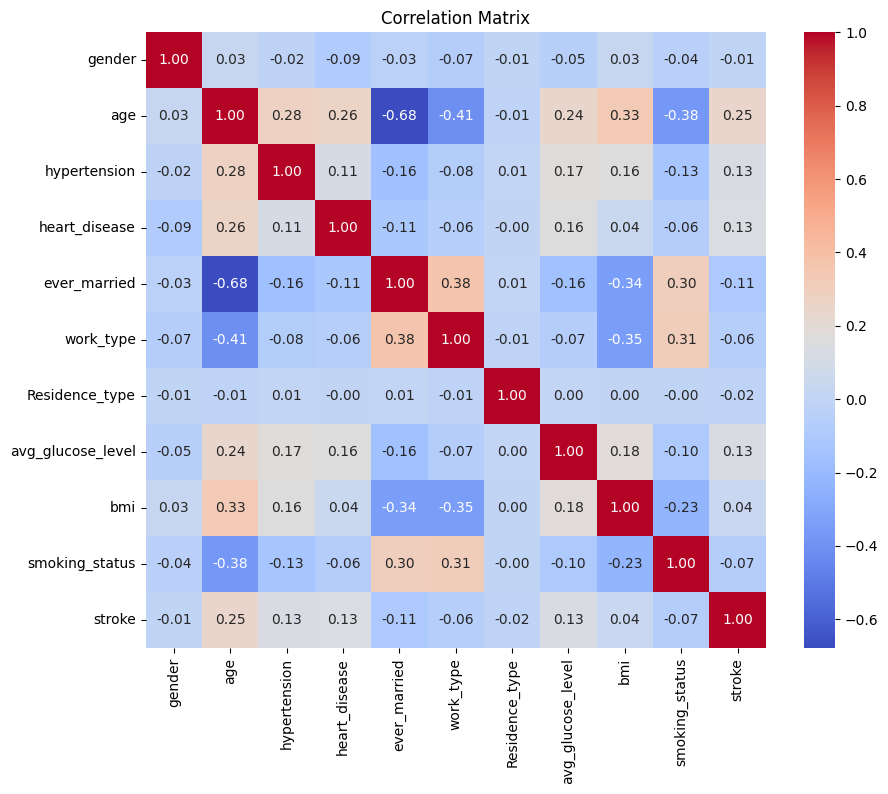

In [48]:
# @title Correlation Matrix

correlation_matrix = df.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

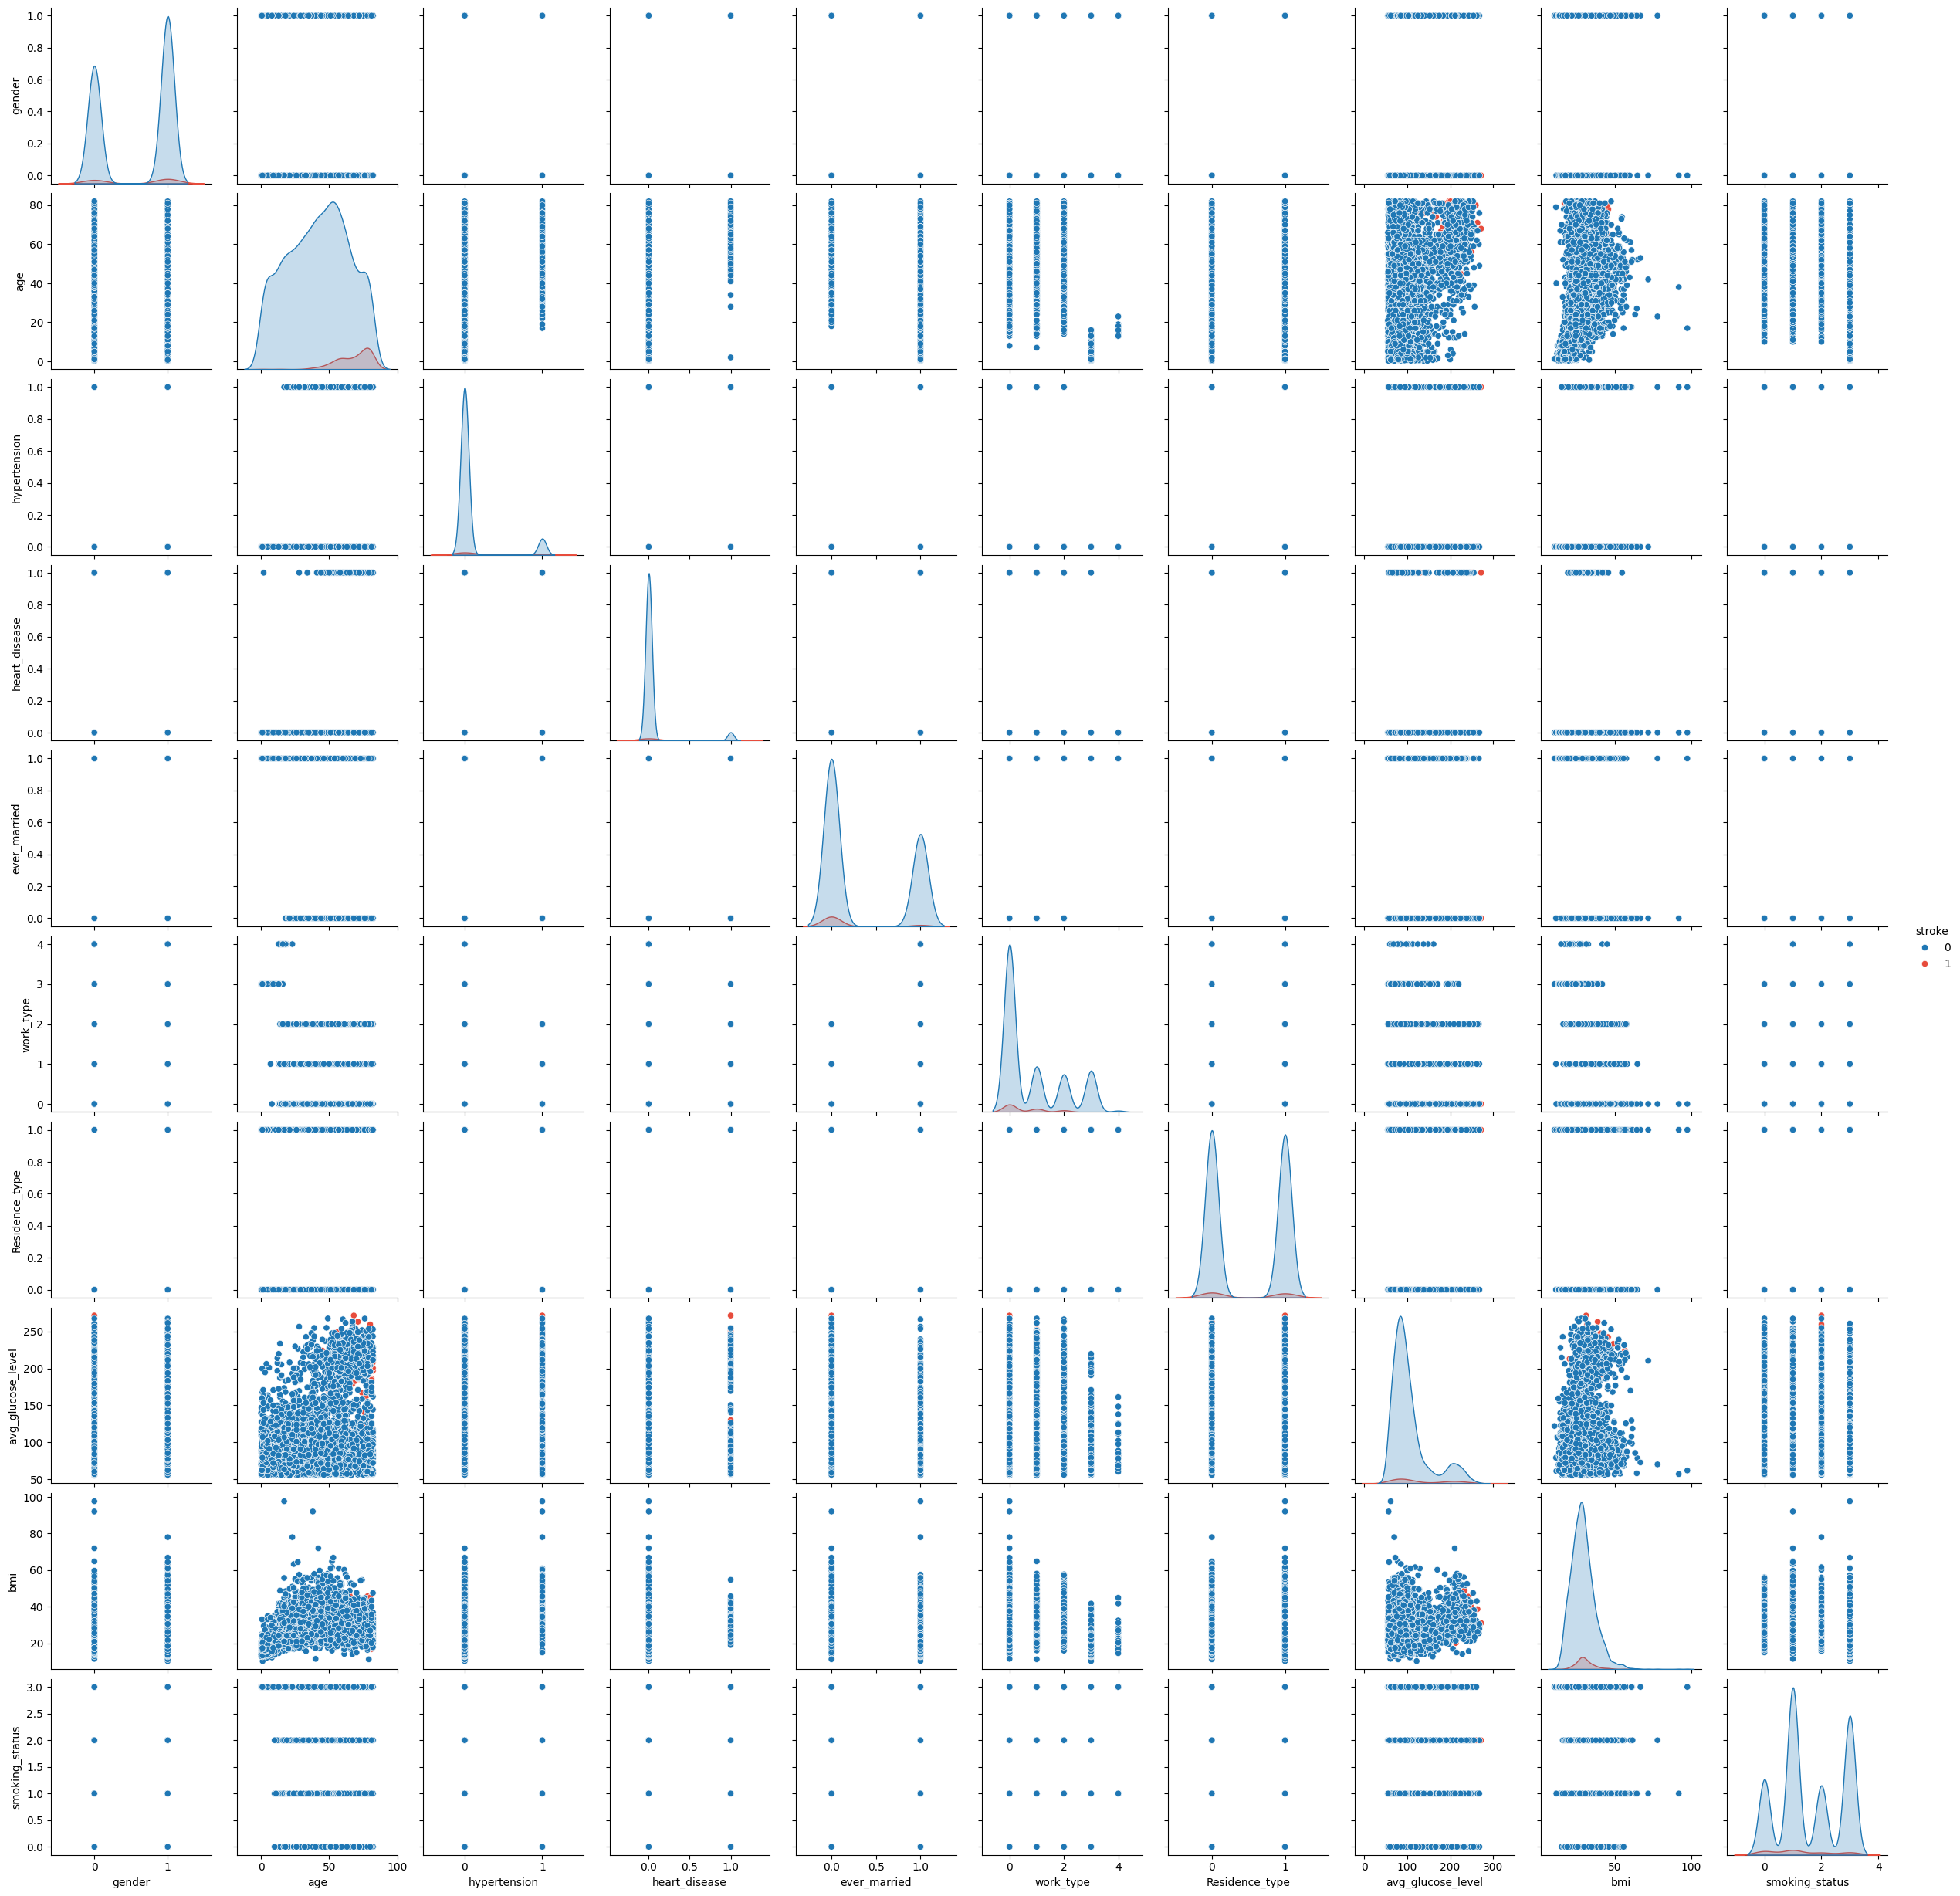

In [ ]:
# @title Summary of Graphs
custom_palette = {0: '#1f77b4', 1: '#e74c3c'}
sns.pairplot(df, hue="stroke", palette=custom_palette)
plt.show()

# EDA

In [ ]:
sns.set_palette("Set2")


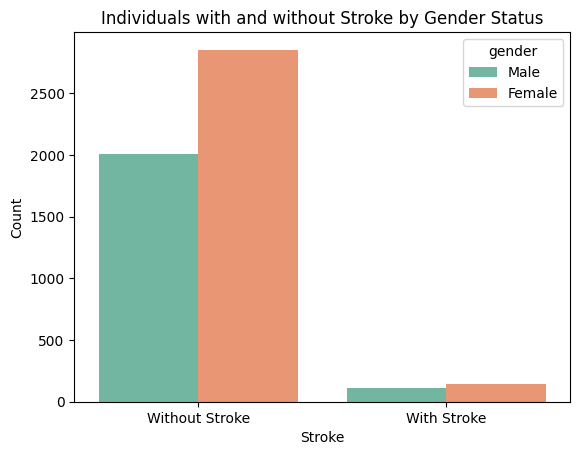

In [ ]:
# @title Histogram: Stroke by Gender

# Plot the count of individuals with and without stroke, segmented by gender status
sns.countplot(data=df, x='stroke', hue='gender')
plt.title('Individuals with and without Stroke by Gender Status')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Without Stroke', 'With Stroke'])
plt.legend(title='gender', labels=['Male', 'Female'])

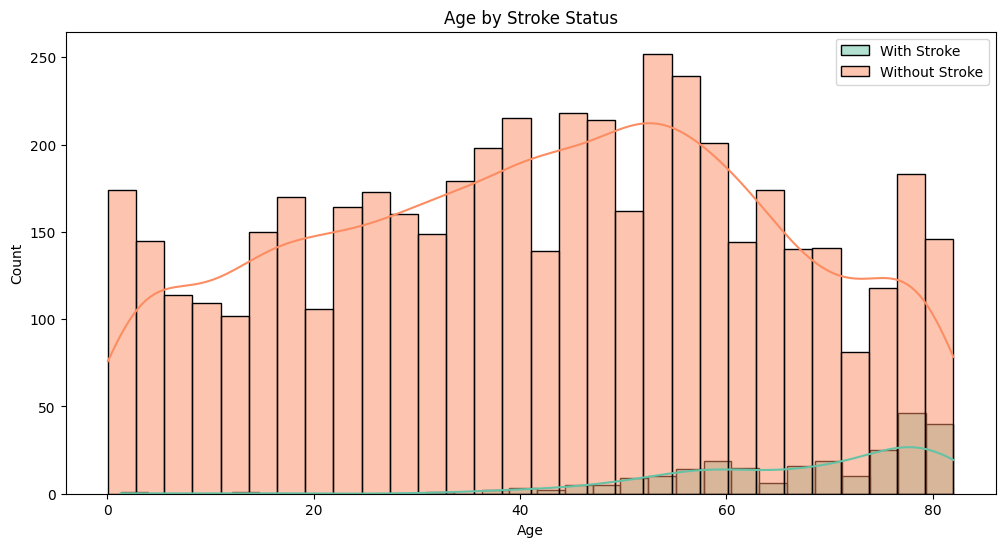

In [ ]:
# @title Histogram: Stroke by Age

# Create separate plots for individuals with and without strokes
plt.figure(figsize=(12, 6))

sns.histplot(data=df[df['stroke'] == 1]['age'], kde=True, label='With Stroke', bins=30)
sns.histplot(data=df[df['stroke'] == 0]['age'], kde=True, label='Without Stroke', bins=30)

plt.title('Age by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

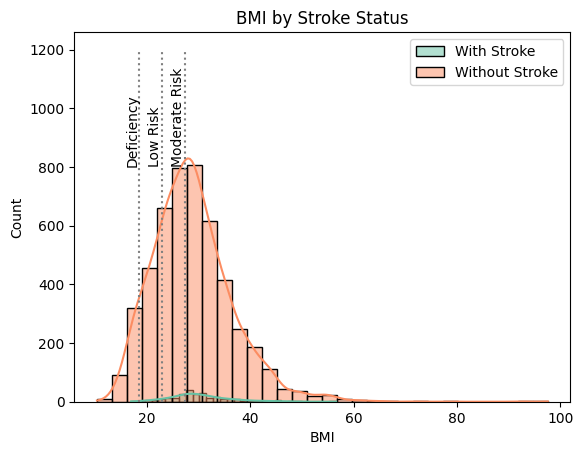

In [ ]:
# @title Histogram: BMI ranges by Stroke

bmi_ranges = [(0, 18.5), (18.5, 22.9), (22.9, 27.4), (27.4, float('inf'))]
labels = ['Deficiency', 'Low Risk', 'Moderate Risk', 'High Risk']

sns.histplot(data=df[df['stroke'] == 1]['bmi'], kde=True, label='With Stroke', bins=30)
sns.histplot(data=df[df['stroke'] == 0]['bmi'], kde=True, label='Without Stroke', bins=30)

# Vertical lines to show BMI ranges and label them
for bmi_range, label in zip(bmi_ranges[:-1], labels):
    plt.vlines(bmi_range[1], ymin=0, ymax=1200, colors='gray', linestyles='dotted')
    plt.text(bmi_range[1], 800, label, rotation=90, verticalalignment='bottom', horizontalalignment='right')


plt.title('BMI by Stroke Status')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.legend()
plt.show()

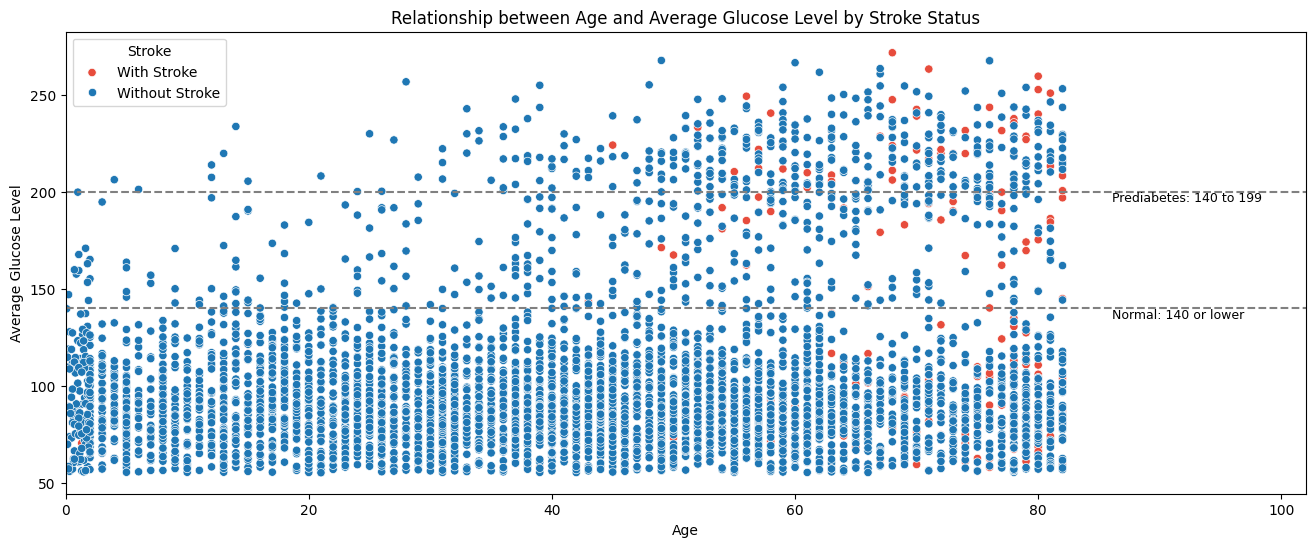

In [ ]:
# @title Scatterplot: Age by Stroke and Avg_glucose_level

plt.figure(figsize=(16, 6))
sns.scatterplot(x='age', y='avg_glucose_level', hue='stroke', data=df, palette={0: '#1f77b4', 1: '#e74c3c'})

glucose_ranges = [(140, 'Normal: 140 or lower'), (200, 'Prediabetes: 140 to 199'), (200, 'Diabetes: 200 or higher')]

for level, label in glucose_ranges:
    if label != 'Diabetes: 200 or higher':
        plt.axhline(y=level, color='gray', linestyle='--')
        plt.text(plt.xlim()[1], level, label, verticalalignment='top', horizontalalignment='left', fontsize=9)

plt.legend(title='Stroke', labels=['With Stroke', 'Without Stroke'], loc='upper left')
plt.title('Relationship between Age and Average Glucose Level by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.xlim(left=0, right=df['age'].max() + 20)
plt.show()

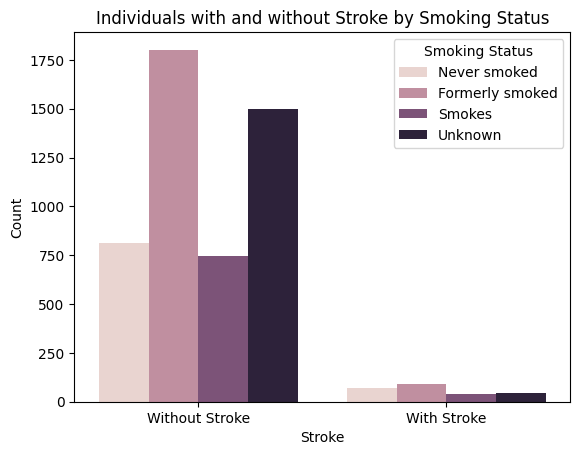

In [ ]:
# @title Bargraph: Individuals with and without stroke, segmented by smoking status
sns.countplot(data=df, x='stroke', hue='smoking_status')
plt.title('Individuals with and without Stroke by Smoking Status')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Without Stroke', 'With Stroke'])
plt.legend(title='Smoking Status', labels=['Never smoked', 'Formerly smoked', 'Smokes','Unknown'])


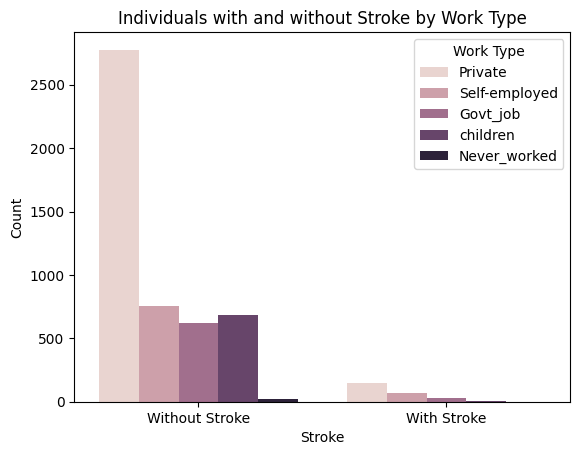

In [13]:
# @title Histogram: Stroke by Work Type

sns.countplot(data=df, x='stroke', hue='work_type')
plt.title('Individuals with and without Stroke by Work Type')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Without Stroke', 'With Stroke'])
plt.legend(title='Work Type', labels=['Private','Self-employed','Govt_job'	,'children','Never_worked'])



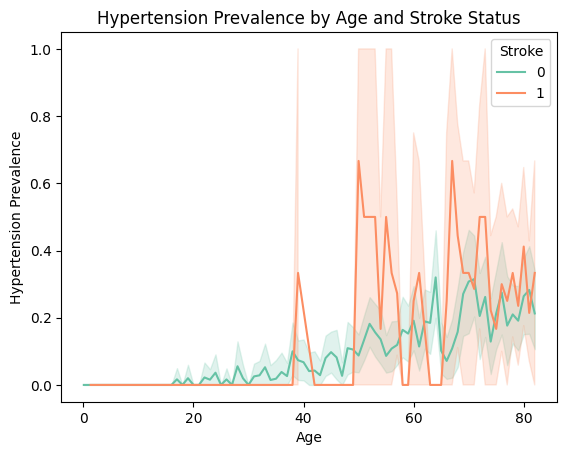

In [ ]:
# @title Lineplot: Hypertension prevalence by age separated by stroke status
sns.lineplot(x='age', y='hypertension', hue='stroke', data=df)
plt.legend(title='Stroke')
plt.title('Hypertension Prevalence by Age and Stroke Status')
plt.xlabel('Age')
plt.ylabel('Hypertension Prevalence')

plt.show()

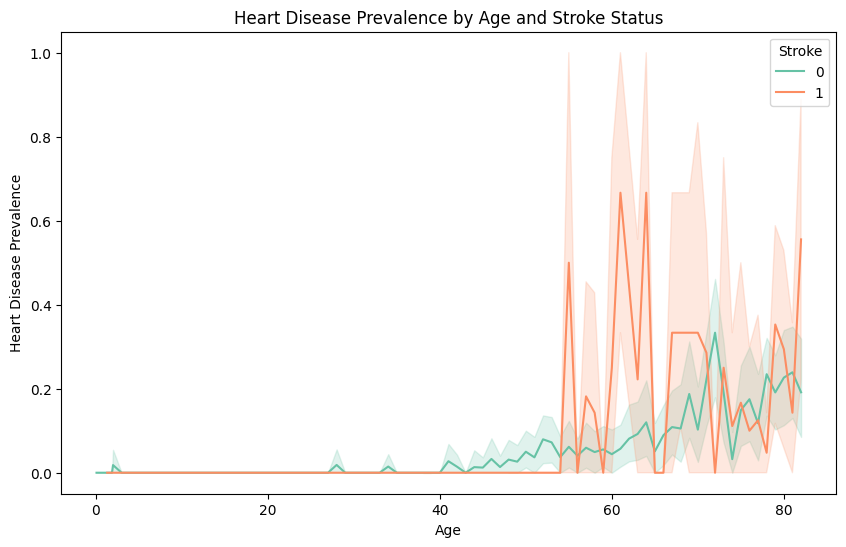

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(x='age', y='heart_disease', hue='stroke', data=df)
plt.title('Heart Disease Prevalence by Age and Stroke Status')
plt.xlabel('Age')
plt.ylabel('Heart Disease Prevalence')
plt.legend(title='Stroke')
plt.show()


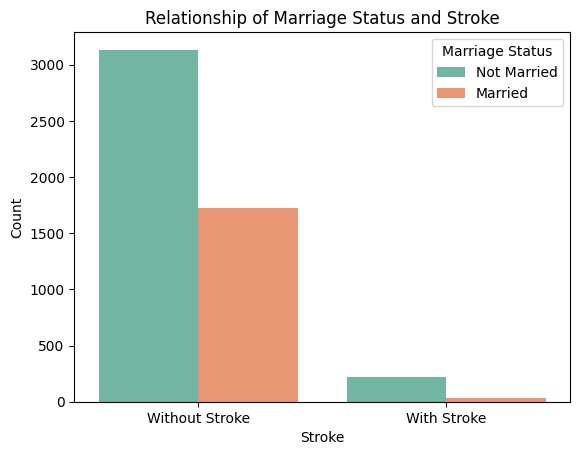

In [ ]:
# prompt: show relationship of marriage status and stroke

import matplotlib.pyplot as plt
sns.countplot(data=df, x='stroke', hue='ever_married')
plt.title('Relationship of Marriage Status and Stroke')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Without Stroke', 'With Stroke'])
plt.legend(title='Marriage Status', labels=['Not Married', 'Married'])
plt.show()


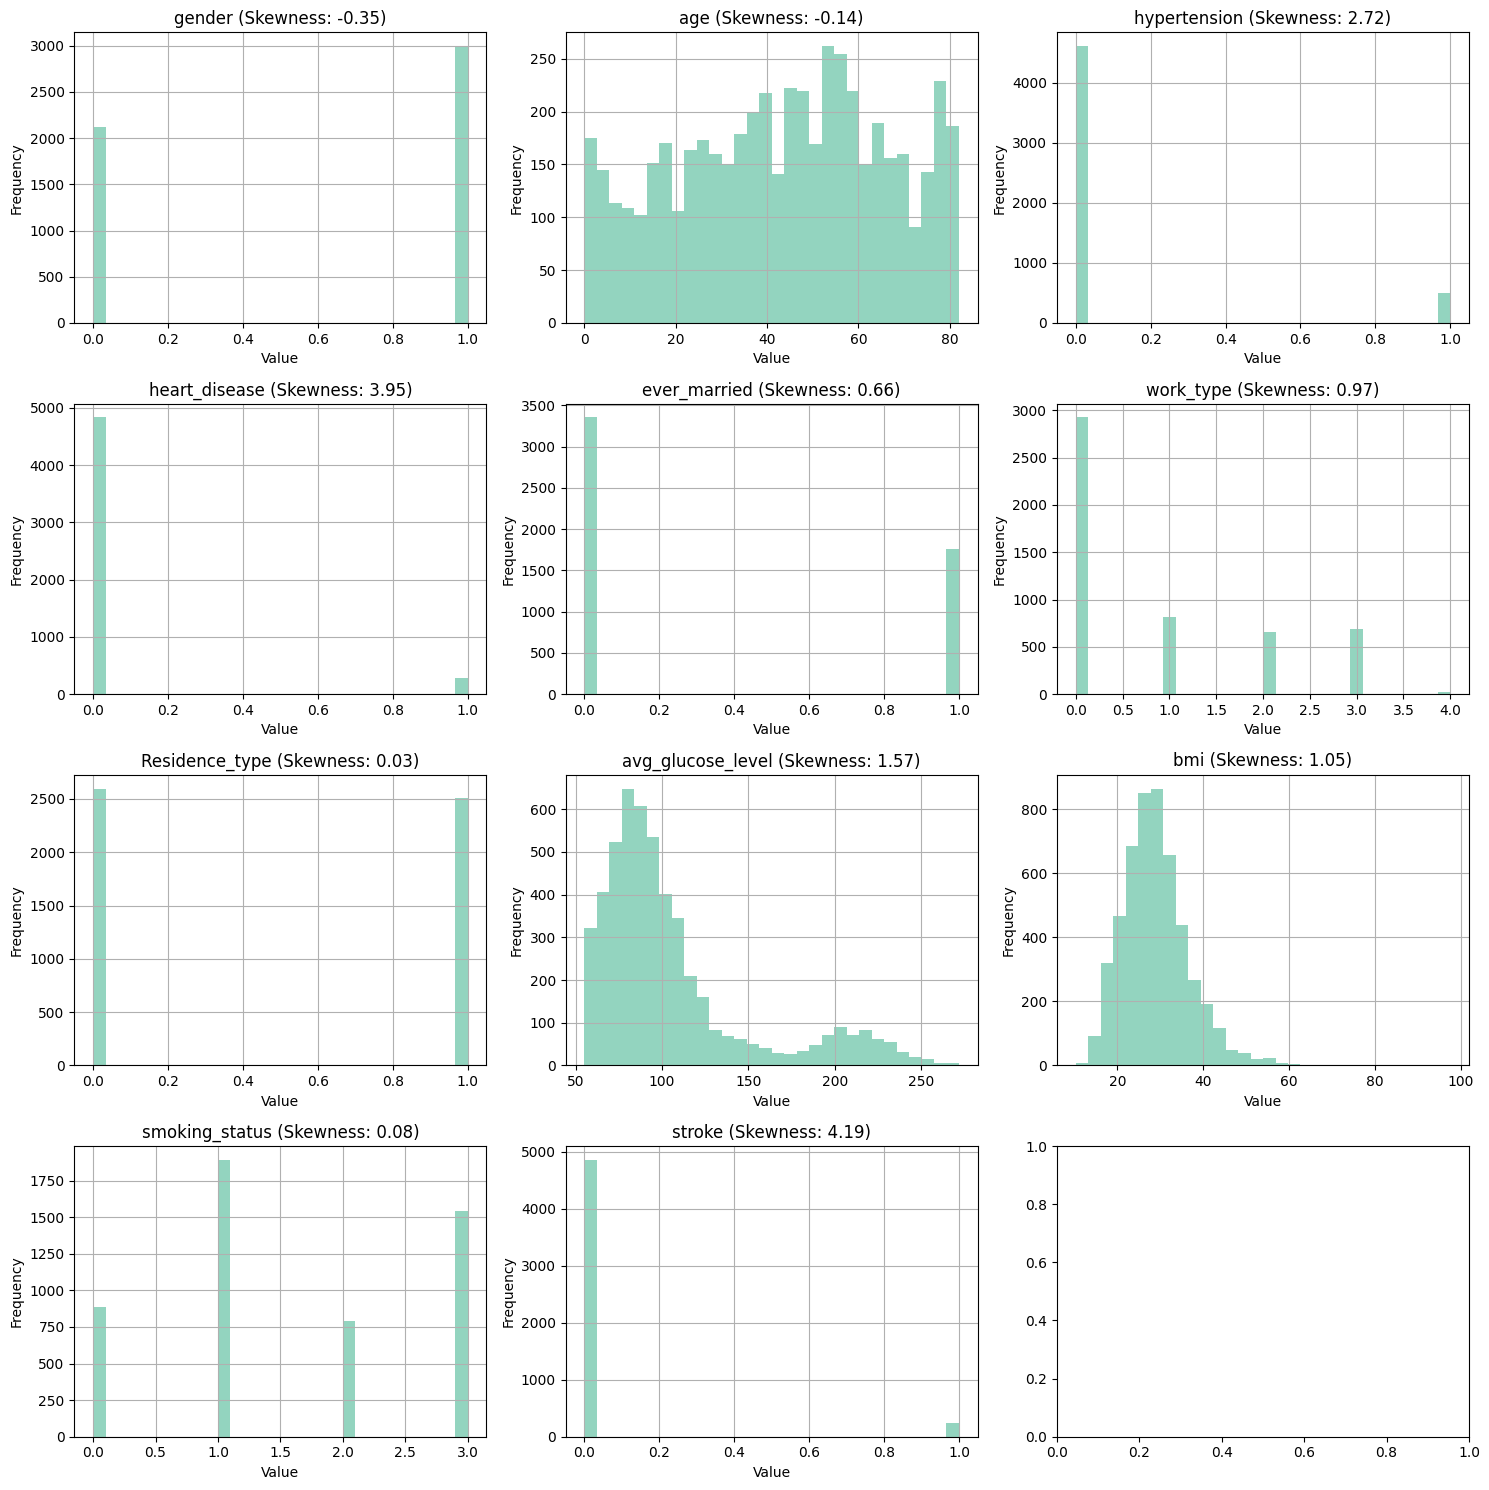

In [ ]:
# @title Skewness of the variables
skewness = df.skew()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i, (col, skew) in enumerate(skewness.items()):
    ax = axes[i // 3, i % 3]
    df[col].hist(ax=ax, bins=30, alpha=0.7)
    ax.set_title(f'{col} (Skewness: {skew:.2f})')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

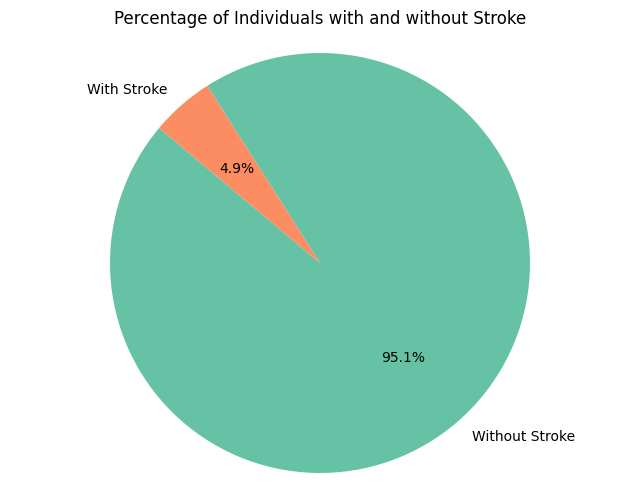

In [ ]:
# @title Piechart: Individuals with and without stroke

stroke_counts = df['stroke'].value_counts()
labels = ['Without Stroke', 'With Stroke']

plt.figure(figsize=(8, 6))
plt.pie(stroke_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Individuals with and without Stroke')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Train Test Split & SMOTE

In [ ]:
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [ ]:
x = df.drop(columns="stroke")
y = df["stroke"]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=2024)

In [ ]:
smote = SMOTE(random_state=2024)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)



#Export to CSV

In [ ]:
test = pd.concat([x_test, y_test], axis=1)

In [ ]:
test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2481,0,0.88,0,0,1,3,0,90.62,22.40,3,0
1644,1,29.00,0,0,1,0,0,81.43,28.70,0,0
3808,1,37.00,0,0,1,2,1,72.08,31.05,0,0
1065,0,67.00,0,0,0,2,0,67.79,26.00,0,0
2182,1,71.00,0,0,0,1,1,249.29,30.30,2,0
...,...,...,...,...,...,...,...,...,...,...,...
2125,0,37.00,0,0,0,0,1,66.17,26.10,1,0
1177,0,23.00,0,0,1,0,0,115.98,22.30,1,0
1817,0,43.00,0,0,0,0,1,62.99,27.00,0,0
4739,1,24.00,0,0,1,0,1,187.99,24.90,2,0


In [ ]:
train_smote = pd.concat([x_train_smote, y_train_smote], axis=1)

In [ ]:
train_smote

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,42.000000,0,0,0,0,1,84.600000,27.000000,2,0
1,0,63.000000,1,0,0,0,1,60.170000,23.500000,2,0
2,1,54.000000,0,0,0,0,0,100.290000,30.200000,1,0
3,0,59.000000,0,0,0,0,1,64.510000,31.500000,1,0
4,0,35.000000,0,0,0,0,1,145.180000,32.600000,2,0
...,...,...,...,...,...,...,...,...,...,...,...
7279,0,58.313341,0,1,0,0,0,214.373588,32.017839,3,1
7280,1,55.557155,0,1,0,0,0,212.121608,37.492804,2,1
7281,1,72.000000,0,0,0,0,0,221.568757,30.135335,1,1
7282,0,78.024919,0,0,0,0,0,203.897598,45.617767,1,1


In [ ]:
level_labels

,0,1,2,3,4
gender,Male,Female,NaN,NaN,NaN
Residence_type,Urban,Rural,NaN,NaN,NaN
smoking_status,never smoked,formerly smoked,smokes,Unknown,NaN
ever_married,No,Yes,NaN,NaN,NaN
work_type,Private,Self-employed,Govt_job,children,Never_worked


In [ ]:
test.to_csv("test.csv", sep=',', index=False, encoding='utf-8')

In [ ]:
train_smote.to_csv("train_smote.csv", sep=',', index=False, encoding='utf-8')

In [ ]:
level_labels.to_csv("level_labels.csv", sep=',', header=True, encoding='utf-8')